### Problem statement: 
JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
We need to forecast the traffic on JetRail for the next 7 months. We have traffic data of JetRail since inception in the test file.

Note: We are given hourly level data and number of commuters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('./data/train1.csv')
del df['ID']
df.head()

,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2


In [3]:
df.shape

(18288, 2)

In [4]:
df['Timestamp'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')

In [5]:
df.index = df.Timestamp

#Resample method in pandas is simiar to groupby method and essentially grouping
#by a certain time span. 'D' indicates daily and mean() indicates we want mean
# during the resampling period
df = df.resample('D').mean()

In [6]:
train = df[0:552]
test = df[552:]

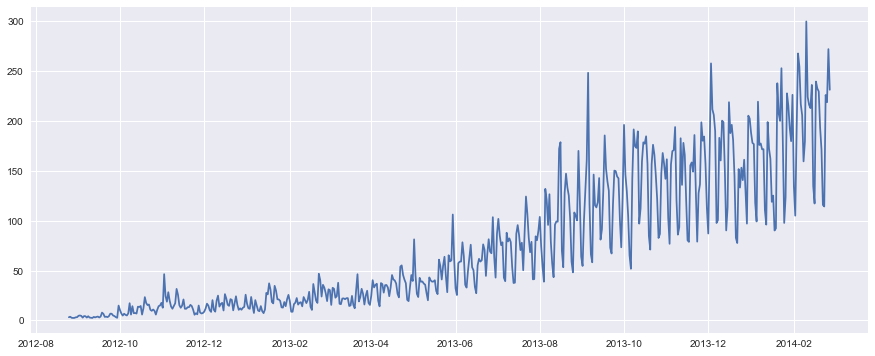

In [7]:
sns.set()
fig= plt.figure(figsize=(15,6))
plt.plot(train['Count'])
plt.show()

#### Method 1 - Naive Method
Most primitive and simplest forecasting method. Under this we assume the next expected point is equal to last observed point.

In [8]:
y_hat = test.copy()
y_hat['Naive'] = train['Count'][-1]

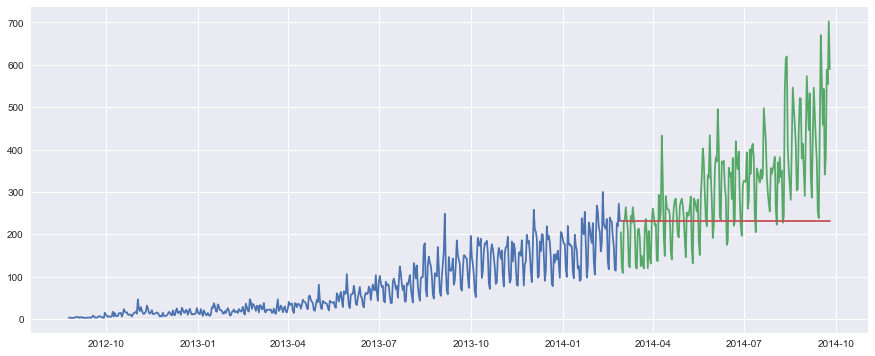

In [9]:
fig = plt.figure(figsize =(15,6))
plt.plot(train.index,train['Count'],label='Train')
plt.plot(y_hat['Count'],label = 'Test')
plt.plot(y_hat['Naive'],label ='Naive')
plt.show()

In [10]:
RMS_naive = sqrt(mean_squared_error(y_hat['Count'], y_hat['Naive']))
print(RMS_naive)

142.61645513


#### Method 2 - Simple Average
Under this approach, the next value is the arithmetic average of all previously observed data points

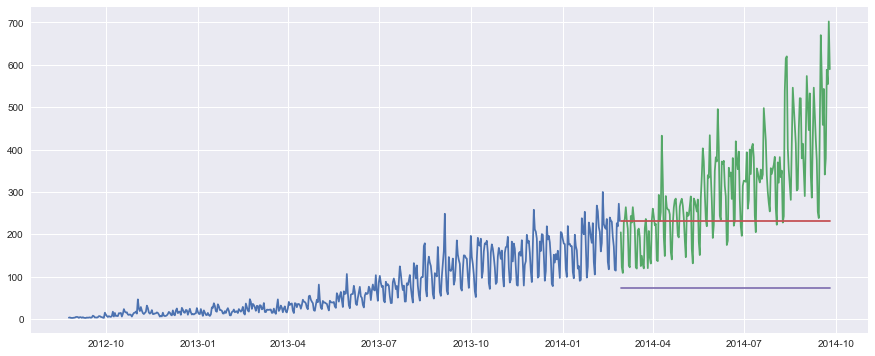

In [11]:
y_hat['SimAvg'] = train['Count'].mean()
fig = plt.figure(figsize =(15,6))
plt.plot(train.index,train['Count'],label='Train')
plt.plot(y_hat['Count'],label = 'Test')
plt.plot(y_hat['Naive'],label ='Naive')
plt.plot(y_hat['SimAvg'],label ='SimAvg')
plt.show()

In [12]:
RMS_simavg = sqrt(mean_squared_error(y_hat['Count'], y_hat['SimAvg']))
print(RMS_simavg)

265.116817991


#### Method 3 - Moving Average
An improvement over simple average, calculation of moving average involves a sliding window of size n.

In [13]:
wndw = 10
temp = train.append(test)
last_sample = len(train['Count'])
length = len(test['Count'])
movavg=[]
for i in range(length):
    mv = temp['Count'][(last_sample-wndw-1+i) :(last_sample+i)].mean()
    movavg.append(mv)

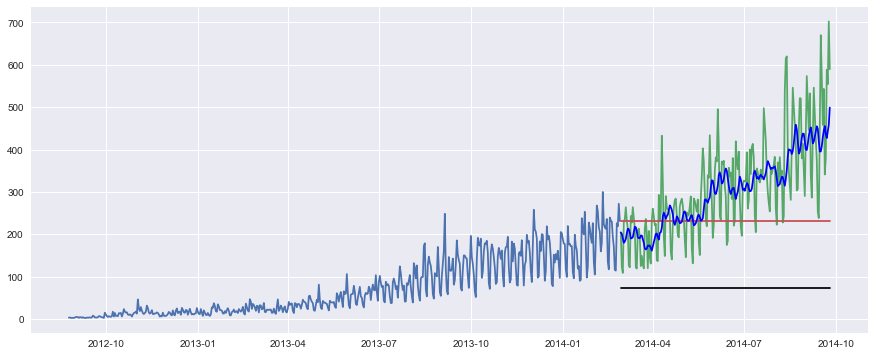

In [14]:
y_hat['MovAvg'] = movavg
fig = plt.figure(figsize =(15,6))
plt.plot(train.index,train['Count'],label='Train')
plt.plot(y_hat['Count'],label = 'Test')
plt.plot(y_hat['Naive'],label ='Naive')
plt.plot(y_hat['SimAvg'],label ='SimAvg',color='black')
plt.plot(y_hat['MovAvg'],label ='MovAvg',color='blue')
plt.show()

In [15]:
RMS_movavg = sqrt(mean_squared_error(y_hat['Count'], y_hat['MovAvg']))
print(RMS_movavg)

87.6689516188


#### Method 4 - Weighted Average
Very similar to moving average but here instead of giving equal importance to all samples in sliding window, we assign a set of weights (which should all add up to 1) to the samples in sliding window. 

In [16]:
wndw = 4
wgts =[0.1,0.2,0.3,0.4]
temp = train.append(test)
last_sample = len(train['Count'])
length = len(test['Count'])
wgtavg=[]
for i in range(length):
    avg = np.dot(temp['Count'][(last_sample-wndw+i) :(last_sample+i)],wgts)
    wgtavg.append(avg)
    

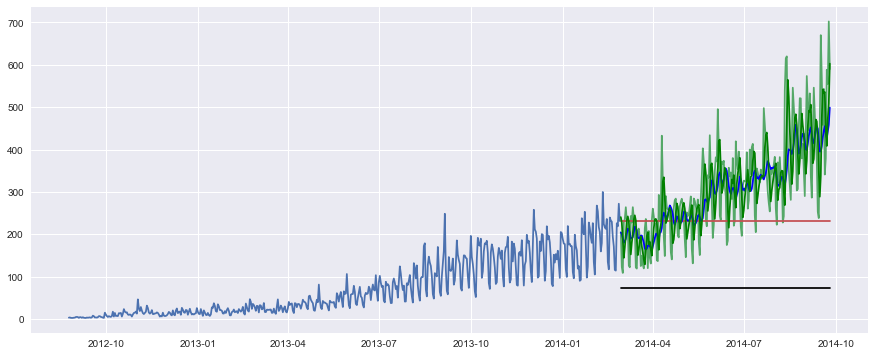

In [17]:
y_hat['WgtAvg'] = wgtavg
fig = plt.figure(figsize =(15,6))
plt.plot(train.index,train['Count'],label='Train')
plt.plot(y_hat['Count'],label = 'Test')
plt.plot(y_hat['Naive'],label ='Naive')
plt.plot(y_hat['SimAvg'],label ='SimAvg',color='black')
plt.plot(y_hat['MovAvg'],label ='MovAvg',color='blue')
plt.plot(y_hat['WgtAvg'],label ='WgtAvg',color='green')
plt.show()

In [18]:
RMS_wgtavg = sqrt(mean_squared_error(y_hat['Count'], y_hat['WgtAvg']))
print(RMS_wgtavg)

92.6110868939


#### Method 5 - Exponential Smoothing
A kind of weighted average where we consider all the datapoints while assigning exponentially smaller weights as we go back in time. 

In [19]:
temp = train.copy()
df = temp.reset_index()
df = df.rename(columns={'Timestamp': 'ds','Count': 'y'})
df.head()
test.head()

,Count
Timestamp,
2014-02-28,204.500000
2014-03-01,122.583333
2014-03-02,108.666667
2014-03-03,228.000000
2014-03-04,236.333333


In [20]:
df['y_orig'] = df['y'] #to store original y values
df['y'] = np.log(df['y'])

In [21]:
model = Prophet()
model.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
futuredata = model.make_future_dataframe(periods=len(test['Count']), freq='d', include_history=1)

In [23]:
forecast = model.predict(futuredata)

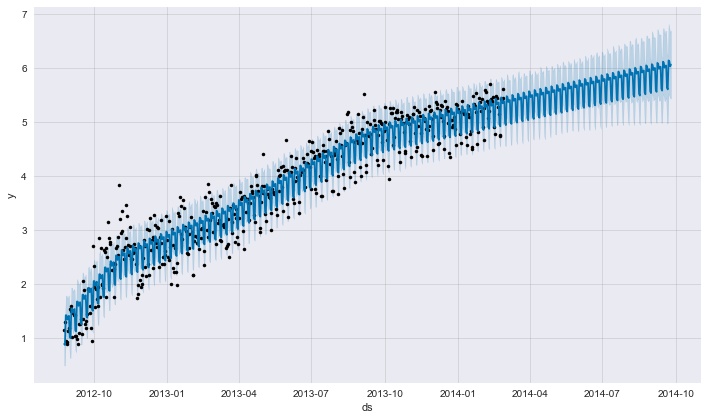

In [24]:
model.plot(forecast)

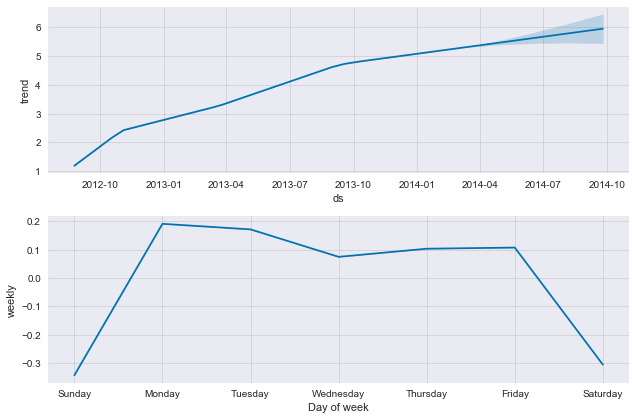

In [25]:
model.plot_components(forecast)

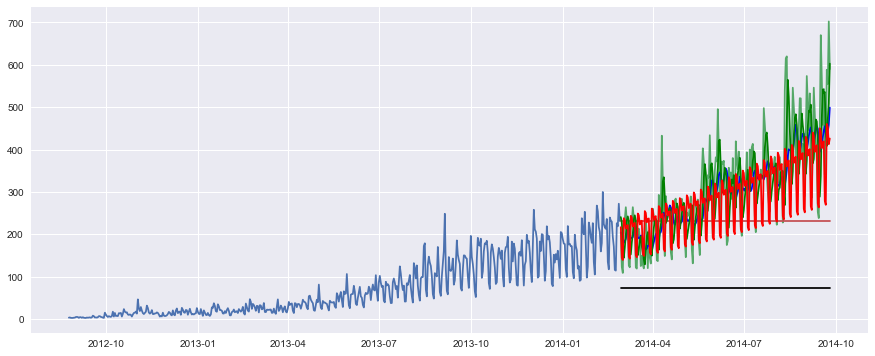

In [30]:
y_hat['ExpSmth']= np.exp(np.array(forecast['yhat'][-(len(test['Count'])):]))
fig = plt.figure(figsize =(15,6))
plt.plot(train.index,train['Count'],label='Train')
plt.plot(y_hat['Count'],label = 'Test')
plt.plot(y_hat['Naive'],label ='Naive')
plt.plot(y_hat['SimAvg'],label ='SimAvg',color='black')
plt.plot(y_hat['MovAvg'],label ='MovAvg',color='blue')
plt.plot(y_hat['WgtAvg'],label ='WgtAvg',color='green')
plt.plot(y_hat['ExpSmth'],label ='ExpSmth',color='red')

plt.show()

In [27]:
RMS_expsmth = sqrt(mean_squared_error(y_hat['Count'], y_hat['ExpSmth']))
print(RMS_expsmth)

67.4926067555


###  Summary of RMSE

In [28]:
print("Root mean square error using  Naive approach", RMS_naive)
print("Root mean square error using Simple Average method", RMS_simavg)
print("Root mean square error using Moving Average method", RMS_movavg)
print("Root mean square error using Weighted Average method", RMS_wgtavg)
print("Root mean square error using Exponential Smoothing method", RMS_expsmth)

('Root mean square error using  Naive approach', 142.61645512986752)
('Root mean square error using Simple Average method', 265.1168179913376)
('Root mean square error using Moving Average method', 87.66895161882536)
('Root mean square error using Weighted Average method', 92.61108689392758)
('Root mean square error using Exponential Smoothing method', 67.49260675549101)


In [29]:
""

''